In [1]:
!pip install mglearn
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn

# 음수표현 라이브러리
plt.rcParams['axes.unicode_minus'] = False

# 경고무시
import warnings
warnings.filterwarnings("ignore")

# 매직명령어 : 시각화 결과가 노트북에 포함되도록
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 8.2 MB/s eta 0:00:00


# 문제정의

- 피마 인디언 당뇨병 예측 데이터 셋
- 당뇨병 여부 판단하는 머신러닝 예측모델을 수렴하고 평가지표를 적용해보자
- 북아메리카 피마 지역 원주민의 2형 당뇨병 결과 데이터


In [2]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [20]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [25]:
# 0의 비율 확인
zero_f = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
total = df.Glucose.count()

for col in zero_f:
    zero_count = df[df[col] == 0][col].count()
    print(f'{col} 피처의 0에 건수는 {zero_count}이고 비율은 {zero_count/total * 100:.2f}%')


Glucose 피처의 0에 건수는 5이고 비율은 0.65%
BloodPressure 피처의 0에 건수는 35이고 비율은 4.56%
SkinThickness 피처의 0에 건수는 227이고 비율은 29.56%
Insulin 피처의 0에 건수는 374이고 비율은 48.70%
BMI 피처의 0에 건수는 11이고 비율은 1.43%


In [65]:
# 0을 결측 처리 후 평균값 대체
zero_features = ['SkinThickness','Insulin']

for col in zero_features :
    df[col].replace(0,np.nan,inplace=True)

mean = df[zero_features].mean()
df[zero_features] = df[zero_features].fillna(mean)

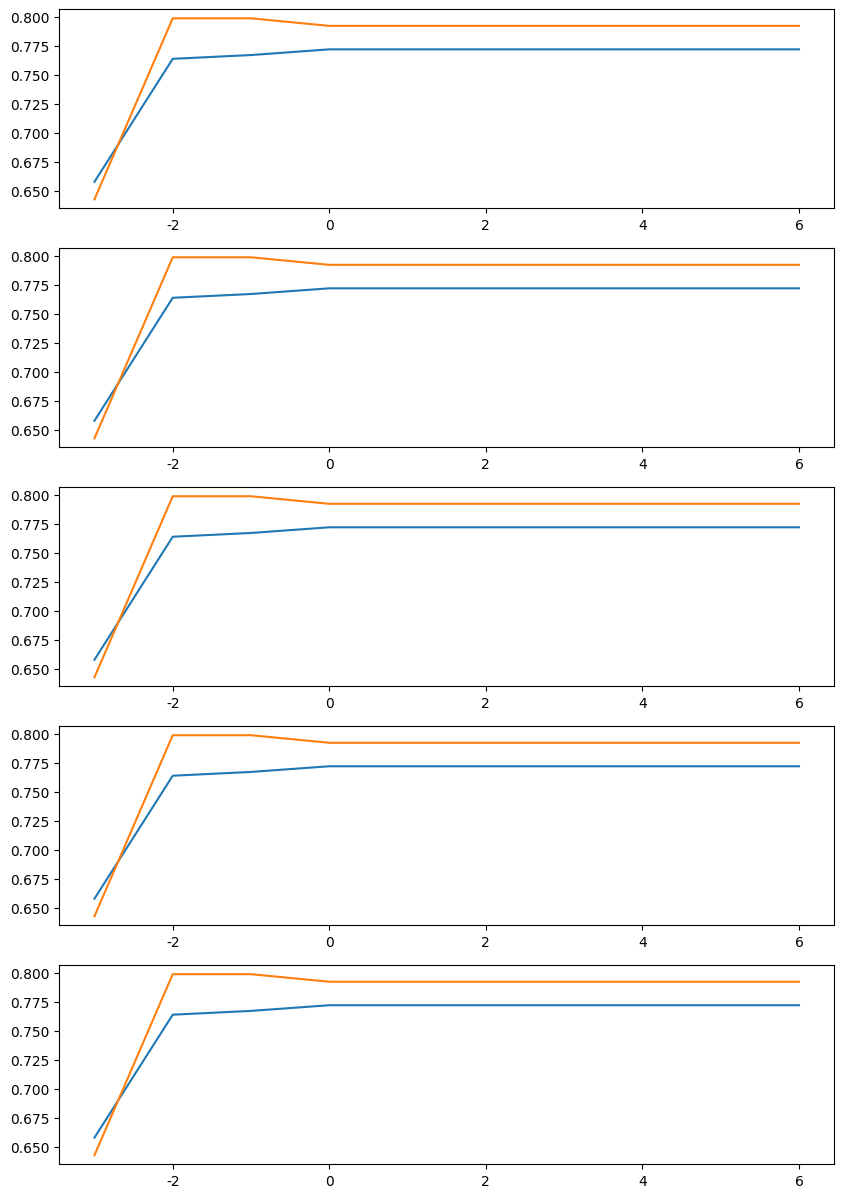

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], random_state=156, stratify=df.Outcome, test_size=0.2)

ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# 로지스틱 회귀
it_list = [100, 200, 300, 400, 500]
C_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]

fig, axes = plt.subplots(nrows=len(it_list), figsize=(10, 15))

for idx, b in enumerate(it_list) :
    train_list = []
    test_list = []
    for a in C_list :
        lr = LogisticRegression(C=a, max_iter=b)
        lr.fit(X_train,y_train)
        train_list.append(lr.score(X_train,y_train))
        test_list.append(lr.score(X_test,y_test))
    axes[idx].plot(np.log10(C_list), train_list)
    axes[idx].plot(np.log10(C_list), test_list)
plt.show()

In [80]:
lr = LogisticRegression(C=1, max_iter=300)
lr.fit(X_train,y_train)
print(lr.score(X_train,y_train))
print(lr.score(X_test,y_test))

0.7719869706840391
0.7922077922077922


In [68]:
# get(실제값, 예측값, 예측확률)
def get(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬(혼돈 행렬)')
    print(confusion)

    print(f'정확도:{accuracy:.4f}, 정밀도:{precision:.4f}, 재현율:{recall:.4f}, F1:{f1:.4f}, AUC:{roc_auc:.4f}')

pred = lr.predict(X_test)
pred_proba = lr.predict_proba(X_test)[:, 1]

get(y_test, pred, pred_proba)

오차 행렬(혼돈 행렬)
[[88 12]
 [20 34]]
정확도:0.7922, 정밀도:0.7391, 재현율:0.6296, F1:0.6800, AUC:0.8130


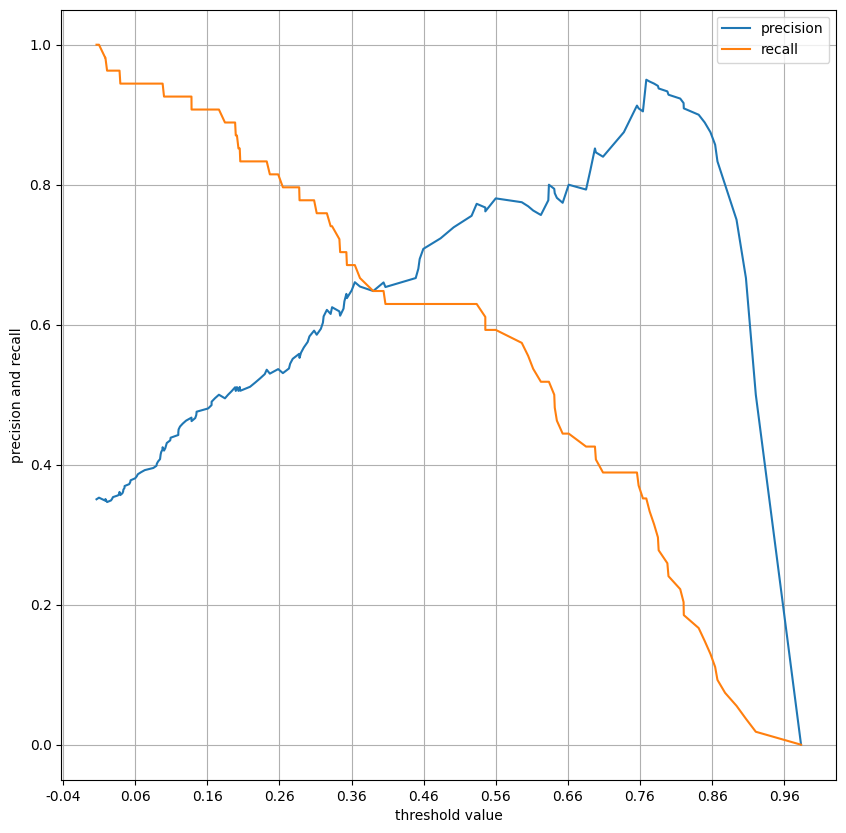

In [69]:
# 정밀도와 재현율 시각화
def prc(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    plt.figure(figsize = (10,10))
    boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:boundary], label='precision')
    plt.plot(thresholds, recalls[0:boundary], label='recall')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('threshold value') # 임계값
    plt.ylabel('precision and recall')
    plt.legend()
    plt.grid()
    plt.show()

prc(y_test, pred_proba)

In [70]:
thresholds = 0.39

predictions = [1 if prob > thresholds else 0 for prob in pred_proba]
get(y_test, predictions, pred_proba)

오차 행렬(혼돈 행렬)
[[81 19]
 [19 35]]
정확도:0.7532, 정밀도:0.6481, 재현율:0.6481, F1:0.6481, AUC:0.8130


- 0값은 데이터가 누락되었거나 결측으로 봐야한다.
- 0값의 비율이 높기 때문에 제거할 수 없다.
- 결측값의 대체 : 연속형(평균), 범주형(최빈값)
- 0값을 평균값으로 대체한 후 다시 스케일링하고 학습하고 평가

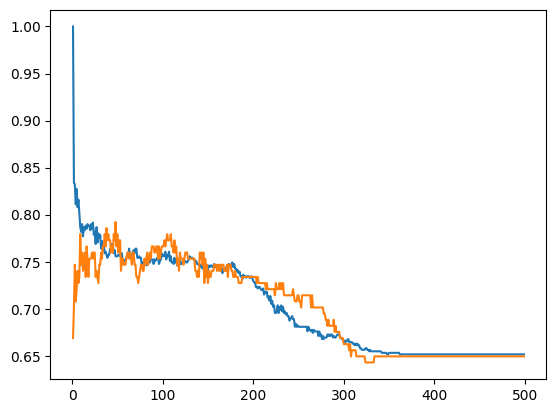

In [71]:
# knn
from sklearn.neighbors import KNeighborsClassifier

idx = list(range(1,500))
train_list = []
test_list =[]

for i in idx :
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    train_list.append(knn.score(X_train,y_train))
    test_list.append(knn.score(X_test,y_test))

plt.plot(idx, train_list)
plt.plot(idx, test_list)
plt.show()

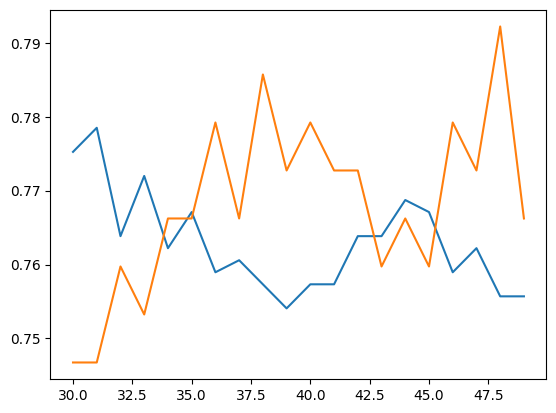

In [72]:
# knn
from sklearn.neighbors import KNeighborsClassifier

idx = list(range(30,50))
train_list = []
test_list =[]

for i in idx :
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    train_list.append(knn.score(X_train,y_train))
    test_list.append(knn.score(X_test,y_test))

plt.plot(idx, train_list)
plt.plot(idx, test_list)
plt.show()

In [73]:
knn = KNeighborsClassifier(n_neighbors=35)
knn.fit(X_train,y_train)
print(knn.score(X_train,y_train))
print(knn.score(X_test,y_test))

0.7671009771986971
0.7662337662337663


In [74]:
pred = knn.predict(X_test)
pred_proba = knn.predict_proba(X_test)[:, 1]

get(y_test, pred, pred_proba)

오차 행렬(혼돈 행렬)
[[86 14]
 [22 32]]
정확도:0.7662, 정밀도:0.6957, 재현율:0.5926, F1:0.6400, AUC:0.8221


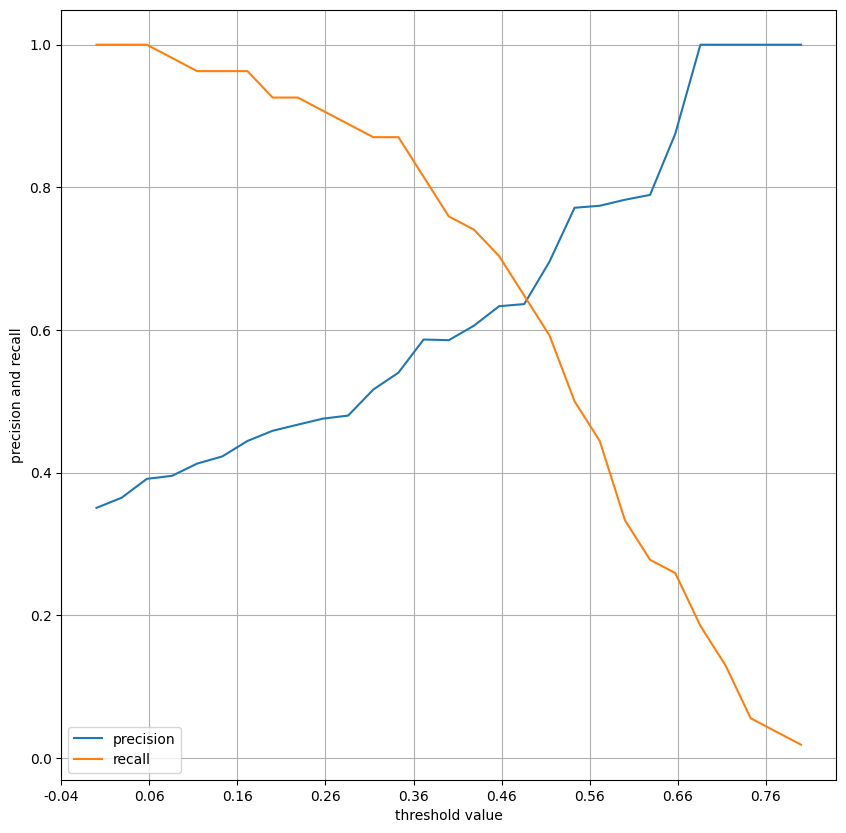

In [75]:
# 정밀도와 재현율 시각화
def prc(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    plt.figure(figsize = (10,10))
    boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:boundary], label='precision')
    plt.plot(thresholds, recalls[0:boundary], label='recall')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('threshold value') # 임계값
    plt.ylabel('precision and recall')
    plt.legend()
    plt.grid()
    plt.show()

prc(y_test, pred_proba)

In [77]:
thresholds = 0.48

predictions = [1 if prob > thresholds else 0 for prob in pred_proba]
get(y_test, predictions, pred_proba)

오차 행렬(혼돈 행렬)
[[80 20]
 [19 35]]
정확도:0.7468, 정밀도:0.6364, 재현율:0.6481, F1:0.6422, AUC:0.8221


In [91]:
from sklearn.preprocessing import Binarizer

def get_clf(y_test, pred_po, threshold, f1_show = False, auc_show = False):
    disp =  pd.DataFrame()

    for thres in threshold:
        # 주어진 임계값에 따른 예측 분류값
        binarizer = Binarizer(threshold = thres)
        binarizer.fit(pred_po)
        thres_pred = binarizer.transform(pred_po)

        # 평가지표
        acc = accuracy_score(y_test, thres_pred)
        pre = precision_score(y_test, thres_pred)
        re = recall_score(y_test, thres_pred)
        f1 = f1_score(y_test, thres_pred)
        auc = roc_auc_score(y_test, thres_pred)

        # 데이터 프레임으로 추출하기 위한 로직
        eval_list = np.array([acc, pre, re, f1, auc]).reshape(-1,1)
        temp = pd.DataFrame(eval_list, columns = [thres],
                            index = ['정확도', '정밀도', '재현율', 'F1', 'AUC'])
        disp =pd.concat([disp, temp], axis=1)

    disp.columns.names=['임계값']

    if f1_show == False :
        disp.drop('F1',axis=0,inplace=True)

    if auc_show == False:
        disp.drop('AUC',axis=0,inplace=True)

    return round(disp, 4)

a = [0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52]
get_clf(y_test, pred_proba.reshape(-1,1), a, True, True)

임계값,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52
정확도,0.7532,0.7468,0.7468,0.7468,0.7662,0.7662,0.7662,0.7727
정밀도,0.6333,0.6364,0.6364,0.6364,0.6957,0.6957,0.6957,0.7714
재현율,0.7037,0.6481,0.6481,0.6481,0.5926,0.5926,0.5926,0.5000
F1,0.6667,0.6422,0.6422,0.6422,0.6400,0.6400,0.6400,0.6067
AUC,0.7419,0.7241,0.7241,0.7241,0.7263,0.7263,0.7263,0.7100
